In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Intensity Transformations

Intensity Transformations (aka Point Operators) are image processing
operators aimed at enhancing the quality (e.g. the contrast) of the
input image.

Point Operators are image processing operators whereby the intensity of a pixel of the
output image is computed based on the intensity of the corresponding
pixel of the input image only (e.g. Thresholding Operator). As such, this operator is just a function
which maps a gray-level into a new gray-level. Any such operator can be implemented as a Look-Up Table (LUT),
which is often convenient especially in case of hardware implementation.

In [18]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage.io
from skimage import data

mpl.rcParams['figure.figsize'] = (12, 6)

In [3]:
def plot_image(image):
    plt.axis('off')
    plt.imshow(image, cmap='gray', interpolation='none')

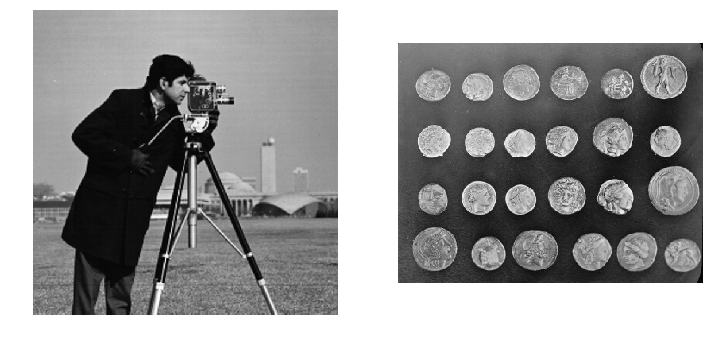

In [19]:
coins, camera = data.coins(), data.camera()
lena = (skimage.io.imread('images/lena_cover.jpg', as_grey=True) * 255).astype(np.uint8)

plt.subplot(121)
plot_image(camera)
plt.subplot(122)
plot_image(coins)
plt.show()

## Histogram

**Definition**: The gray-level histogram of an image is simply a function associating to each gray-level the number of pixels in the image taking that level.

The histogram provides often useful information on image content, although it
must be highlighted that it does not encode any information related to the
spatial distribution of intensities.

Normalization of histogram entries by the total number of pixels yield relative
frequencies of occurrence of gray-levels, which can be interpreted as their
probabilities. Accordingly, the normalized histogram can be thought of as the
pmf (probability mass function) of the discrete random variable given by the
gray-level of a randomly picked pixel in the image.

In [57]:
def plot_histogram(h_image):
    idx_not_zero = np.where(h_image[0] != 0)
    
    non_zero_counts = np.array(h_image[0])[idx_not_zero]
    non_zero_values = np.array(h_image[1])[idx_not_zero]
    
    plt.gca().fill_between(non_zero_values, 0, non_zero_counts)
    plt.plot(non_zero_values, non_zero_counts)

In [58]:
def histogram(image):
    
    values, counts = np.unique(image, return_counts=True)
    values_to_idx = {v:idx for idx, v in enumerate(values)}
    
    return np.array([counts[values_to_idx[i]] if i in values else 0 for i in range(256)]), np.arange(256)

In [59]:
from skimage import exposure

h_camera = histogram(camera)
h_coins = histogram(coins)

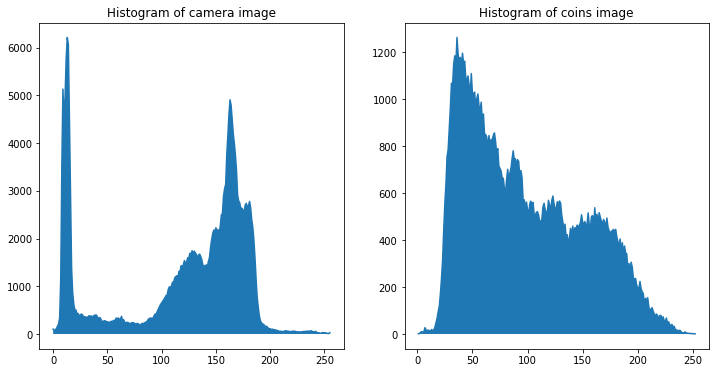

In [60]:
plt.subplot(121)
plt.title('Histogram of camera image')
plot_histogram(h_camera)

plt.subplot(122)
plt.title('Histogram of coins image')
plot_histogram(h_coins)

plt.show()

# Linear Contrast Stretching

An image featuring a small gray-level range has likely poor contrast.
The contrast can be enhanced by linearly stretching the intensities to
span a larger interval (typically, the full available range).

Should most pixel lie in a small interval while there exist a few dark and
bright outliers, the linear function would approximate the identity and
thus be ineffective. In such a case, rmin and rmax can be taken equal to
some percentiles of the distribution (e.g. 5% and 95%), with smaller and
higher input intensities mapped to smin and smax respectively.


$$ s = \frac{s_{max} - s_{min}}{r_{max} - r_{min}} (r - r_{min}) + s_{min} $$

In [61]:
def linear_contrast_stretching(image, percentiles=(5, 95)):
    
    p_low = np.percentile(image, percentiles[0])
    p_high = np.percentile(image, percentiles[1])
    
    return exposure.rescale_intensity(image, in_range=(p_low, p_high))

In [62]:
lcs_1 = linear_contrast_stretching(camera, (1, 99))
lcs_5 = linear_contrast_stretching(camera, (5, 95))
lcs_10 = linear_contrast_stretching(camera, (10, 90))

h_lcs1 = exposure.histogram(lcs_1)
h_lcs5 = exposure.histogram(lcs_5)
h_lcs10 = exposure.histogram(lcs_10)

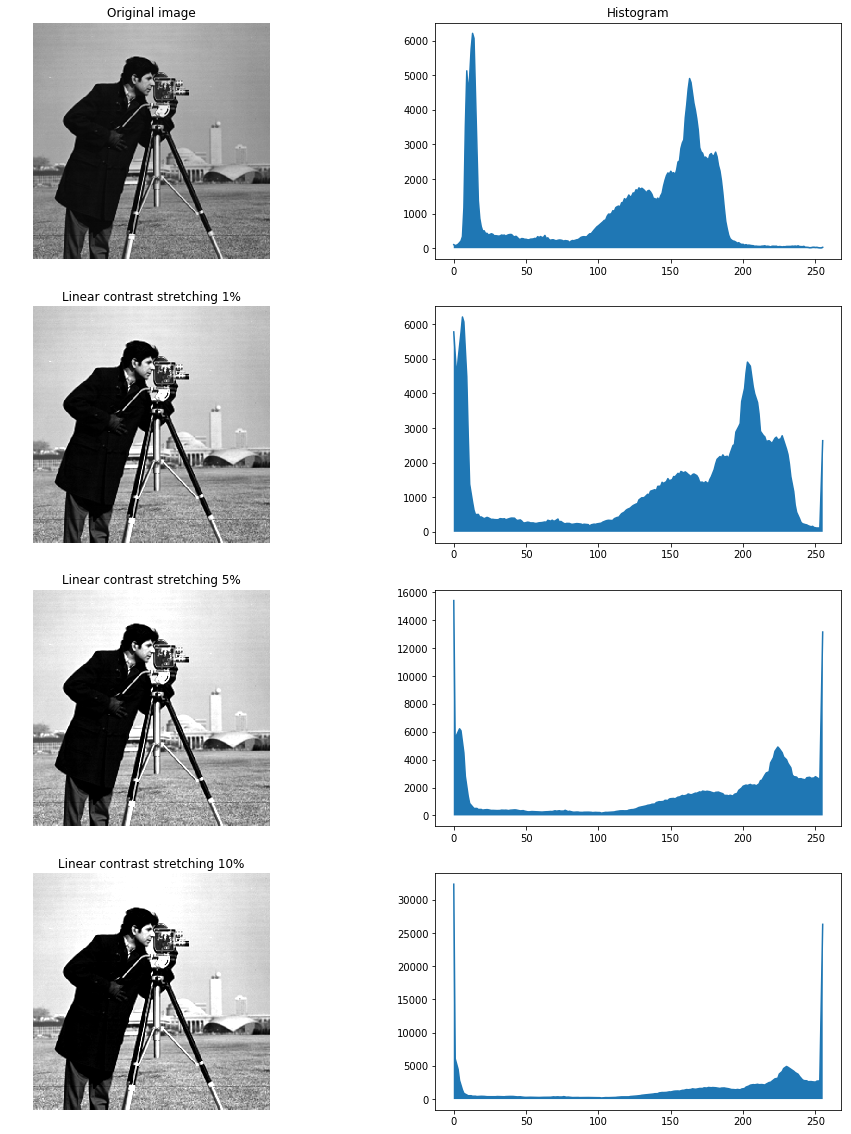

In [63]:
plt.figure(figsize=(16, 20))

plt.subplot(421)
plt.title('Original image')
plot_image(camera)

plt.subplot(422)
plt.title('Histogram')
plot_histogram(h_camera)

plt.subplot(423)
plt.title('Linear contrast stretching 1%')
plot_image(lcs_1)

plt.subplot(424)
plot_histogram(h_lcs1)

plt.subplot(425)
plt.title('Linear contrast stretching 5%')
plot_image(lcs_5)

plt.subplot(426)
plot_histogram(h_lcs5)

plt.subplot(427)
plt.title('Linear contrast stretching 10%')
plot_image(lcs_10)

plt.subplot(428)
plot_histogram(h_lcs10)

# Exponential Operator

It is sometimes desirable to selectively enhance the contrast in either
dark (under-exposed) or bright (over-exposed) areas of the image.
Linear stretching, though, would expand the contrast uniformly.

A non-linear mapping, such as the Exponential Operator, can
be deployed:

$$ y = x^r, x \in [0,1] $$

Thus, taking $r<1$ would stretch the intensity dynamics of dark areas and shrink that of bright ones, which turns out effective to improve underexposed images. The opposite behaviour is achieved with $r>1$, which therefore can be used to enhance over-exposed images.

In [64]:
def exponential_constrast_stretching(image, r):
    
    contr = (image / 255.) ** r
    return (contr * 255).astype(np.uint8)

In [65]:
exp_07 = exponential_constrast_stretching(camera, 0.7)
exp_15 = exponential_constrast_stretching(camera, 1.5)

h_exp_07 = exposure.histogram(exp_07)
h_exp_15 = exposure.histogram(exp_15)

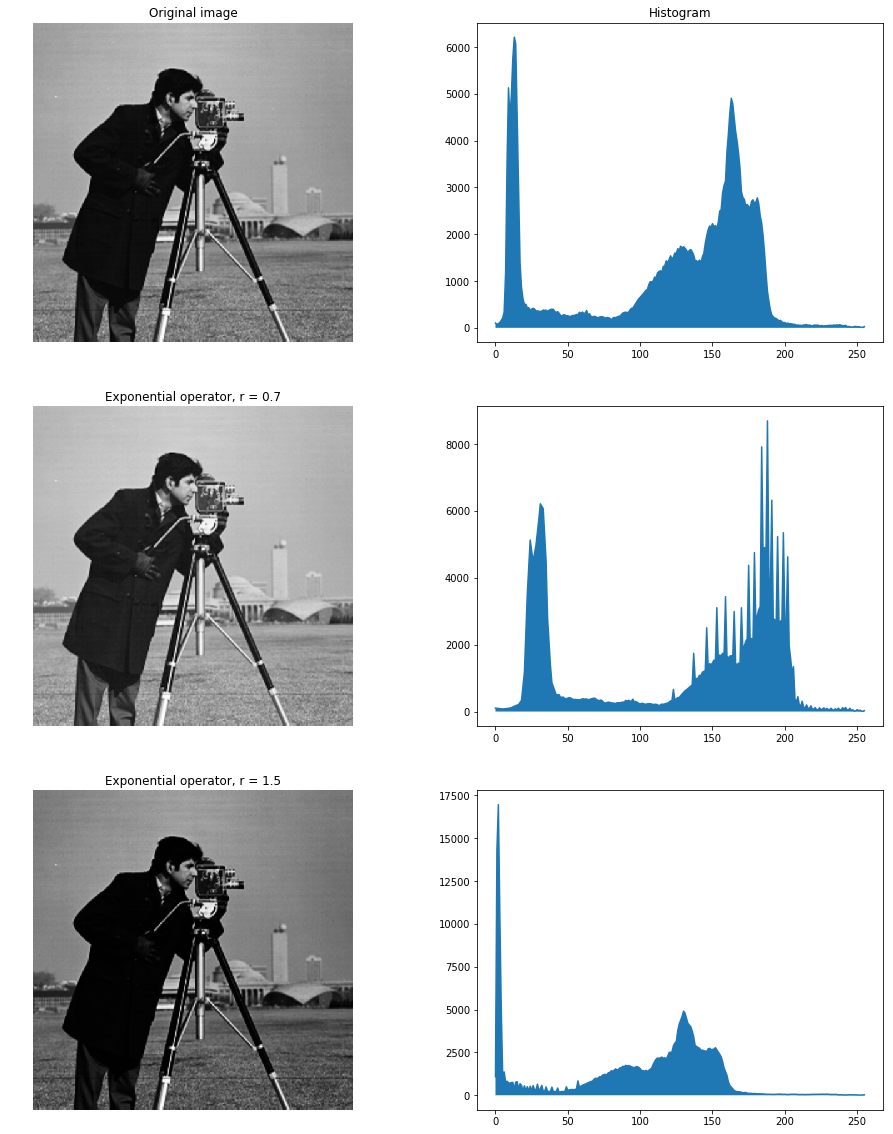

In [66]:
plt.figure(figsize=(16, 20))

plt.subplot(321)
plt.title('Original image')
plot_image(camera)

plt.subplot(322)
plt.title('Histogram')
plot_histogram(h_camera)

plt.subplot(323)
plt.title('Exponential operator, r = 0.7')
plot_image(exp_07)

plt.subplot(324)
plot_histogram(h_exp_07)

plt.subplot(325)
plt.title('Exponential operator, r = 1.5')
plot_image(exp_15)

plt.subplot(326)
plot_histogram(h_exp_15)

# Histogram Equalization

Spreads uniformly pixel intensities across the whole available
range, which usually improves the contrast. Unlike linear
stretching, which may require manual intervention to set $r_{min}$ and
$r_{max}$, HE provides fully automatic contrast enhancement.

More formally, HE maps the gray-level of the input image so that
the histogram of the output image turns out (ideally) flat.

![title](images/heqtrans.gif)

In [67]:
def get_cdf(histogram):
    
    n_pixels = np.sum(histogram[0])
    cdf = np.cumsum(histogram[0]).astype(np.float)
    return cdf / cdf.max()
    
    
def histogram_equalization(image, histogram=None, return_cdf=False):
    
    if histogram is None:
        histogram = exposure.histogram(image)
        
    cdf = get_cdf(histogram)
    cdf = (cdf * 255).astype(np.uint8)
    
    equalized_image = cdf[image]
    
    if return_cdf:
        return equalized_image, cdf
    else:
        return equalized_image

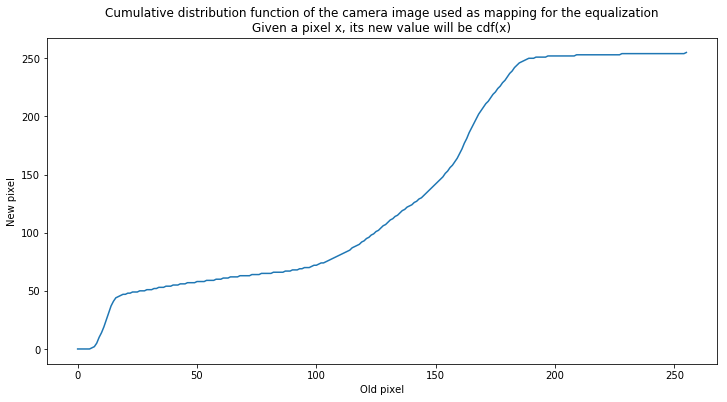

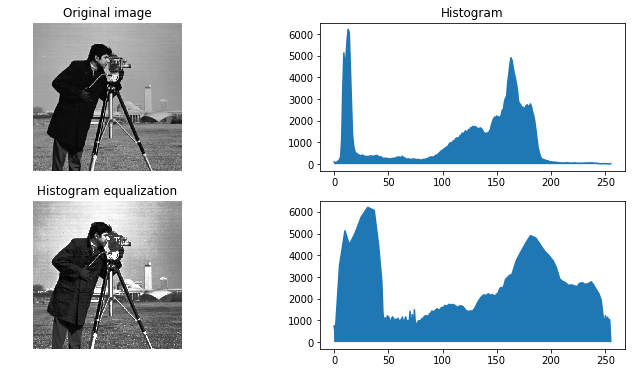

In [68]:
eq_camera, cdf_camera = histogram_equalization(camera, h_camera, return_cdf=True)

plt.title('Cumulative distribution function of the camera image used as mapping for the equalization\nGiven a pixel x, its new value will be cdf(x)')
plt.plot(cdf_camera)
plt.xlabel('Old pixel')
plt.ylabel('New pixel')
plt.show()


plt.subplot(221)
plt.title('Original image')
plot_image(camera)

plt.subplot(222)
plt.title('Histogram')
plot_histogram(h_camera)

plt.subplot(223)
plt.title('Histogram equalization')
plot_image(eq_camera)

plt.subplot(224)
plot_histogram(exposure.histogram(eq_camera))

plt.show()

# Histogram Matching

**Question**: If G is not invertible, what values am I going to take?

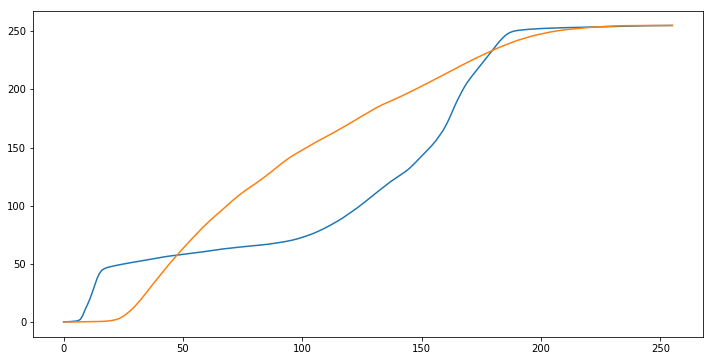

In [69]:
plt.plot(get_cdf(h_camera) * 255)
plt.plot(get_cdf(h_coins) * 255)

In [70]:
def histogram_matching(source, target):
    
    h_source = exposure.histogram(source)
    h_target = exposure.histogram(target)
    
    T = (get_cdf(h_source) * 255).astype(np.uint8)
    G = (get_cdf(h_target) * 255).astype(np.uint8)
    
    interp_target_values = np.interp(G, T, h_target[1]).astype(np.uint8)
    
    Tx = T[source]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   1,   1,   2,   2,   3,   4,
         6,   8,   9,  11,  13,  16,  18,  21,  23,  26,  28,  31,  34,
        36,  39,  41,  44,  46,  49,  51,  54,  56,  58,  61,  63,  65,
        67,  69,  72,  74,  76,  78,  80,  82,  84,  86,  88,  90,  92,
        93,  95,  97,  99, 101, 103, 104, 106, 108, 109, 111, 112, 114,
       115, 117, 118, 119, 121, 122, 124, 125, 127, 129, 130, 132, 134,
       135, 137, 138, 140, 141, 143, 144, 145, 146, 147, 149, 150, 151,
       152, 153, 155, 156, 157, 158, 159, 160, 161, 162, 163, 165, 166,
       167, 168, 169, 170, 172, 173, 174, 175, 177, 178, 179, 180, 181,
       183, 184, 185, 186, 187, 188, 189, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208,
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 232, 23

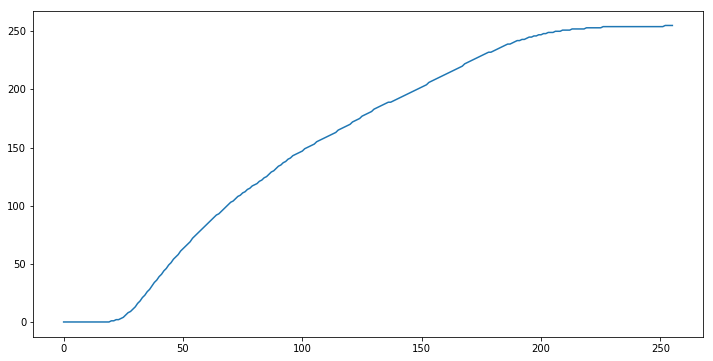

In [76]:
T = (get_cdf(h_camera) * 255).astype(np.uint8)
G = (get_cdf(h_coins) * 255).astype(np.uint8)
plt.plot(G)
G

array([  5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         5.        ,   5.        ,   5.        ,   5.        ,
         6.        ,   6.        ,   7.        ,   7.        ,
         7.33333333,   7.66666667,   8.2       ,   8.6       ,
         8.8       ,   9.25      ,   9.75      ,  10.4       ,
        10.8       ,  11.33333333,  11.66666667,  12.16666667,
        12.5       ,  13.        ,  13.5       ,  13.83333333,
        14.5       ,  15.        ,  16.        ,  18.        ,
        25.        ,  31.        ,  39.        ,  45.        ,
        53.        ,  63.        ,  72.        ,  81.        ,
        89.        ,  94.        , 100.        , 103.        ,
       105.        , 107.        , 109.        , 111.        ,
       113.        , 114.5       , 116.        , 118.  